# Run for a normal segment - epileptic comparison

* patient 24
* recording 01

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sampling frequency: 256.0 Hz
Shape of loaded data: (22, 921600)
Expected shape from metadata: (22, 921600)
Loaded channel FP1-F7 with 921600 samples
Loaded channel data with shape: (921600,)
Loaded times with shape: (921600,)
Loaded metadata with keys: dict_keys(['channels', 'sfreq', 'times'])


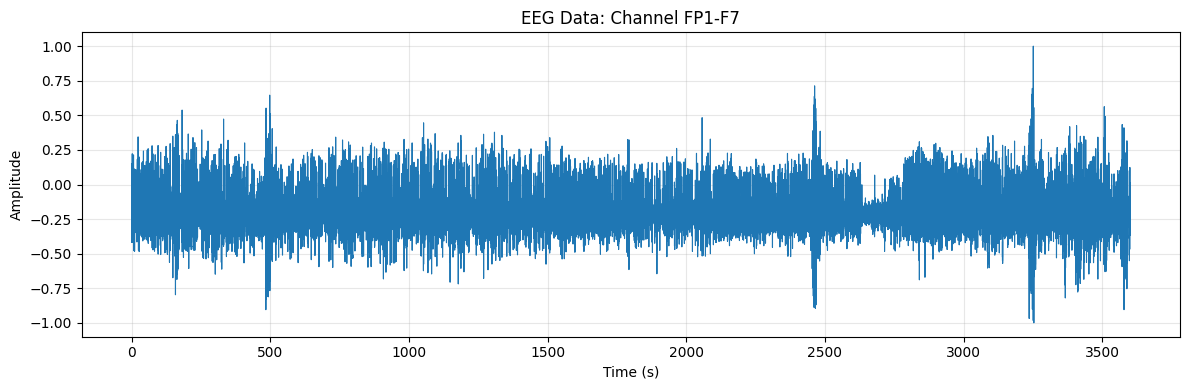

Compare phase space reconstruction for 10 normal vs 10 epileptic 1-sec segments.
100050
629000
creating {n_vectors} vectors
Created 449 phase space vectors with m=4 and tau=21
creating {n_vectors} vectors
Created 449 phase space vectors with m=4 and tau=21


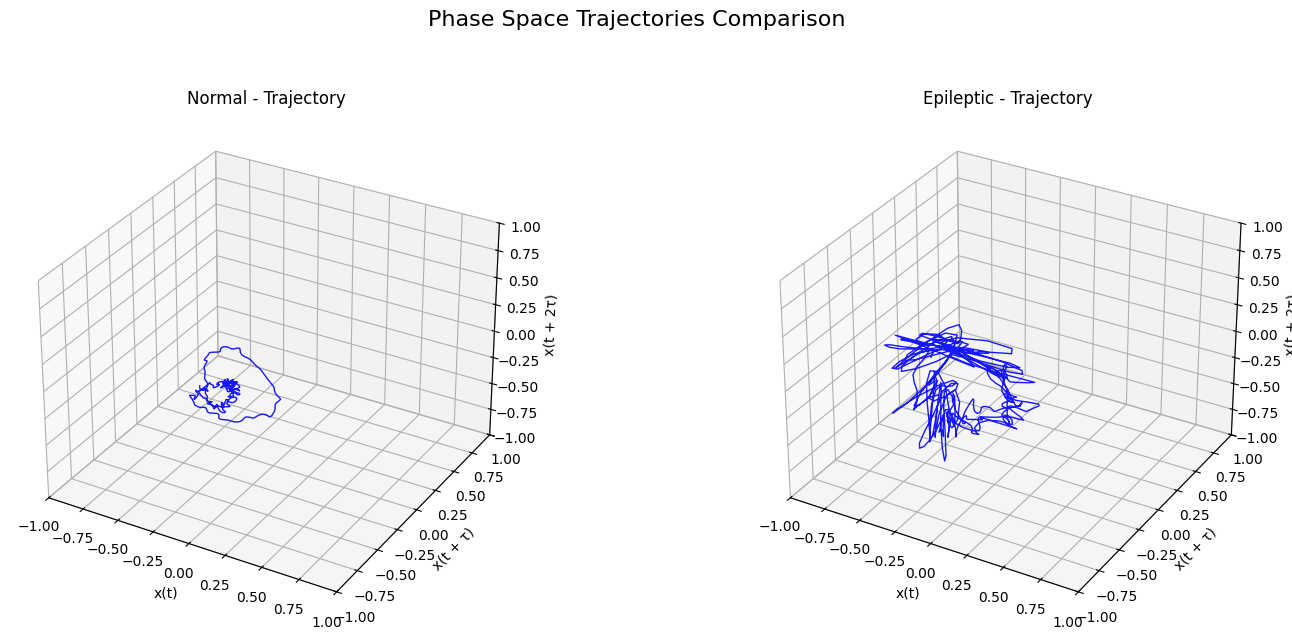

Creating 2.0-second segments


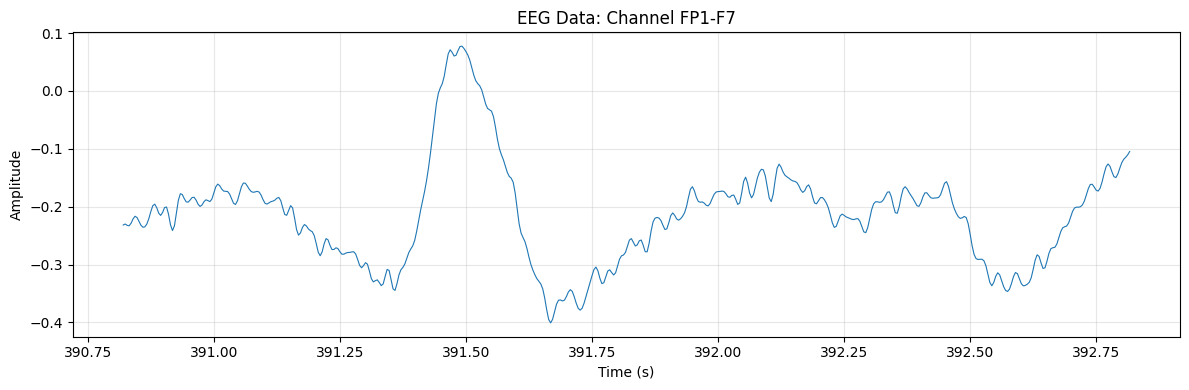

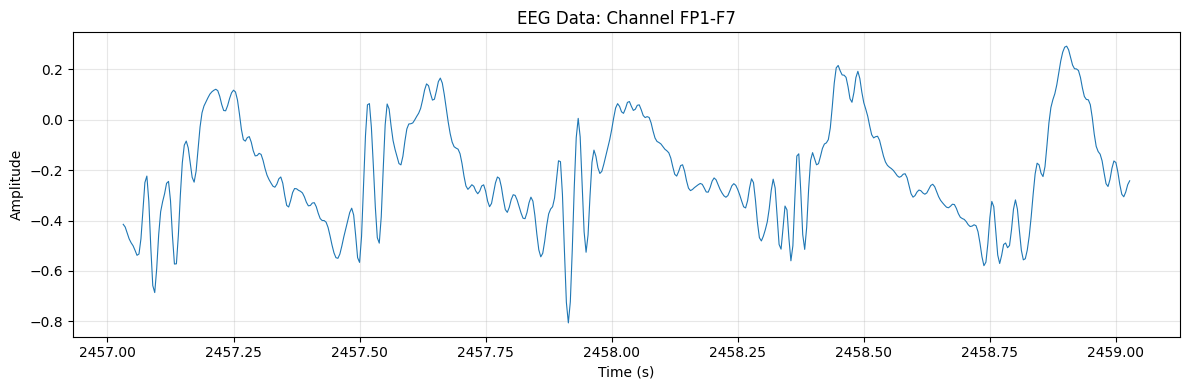

AMI process


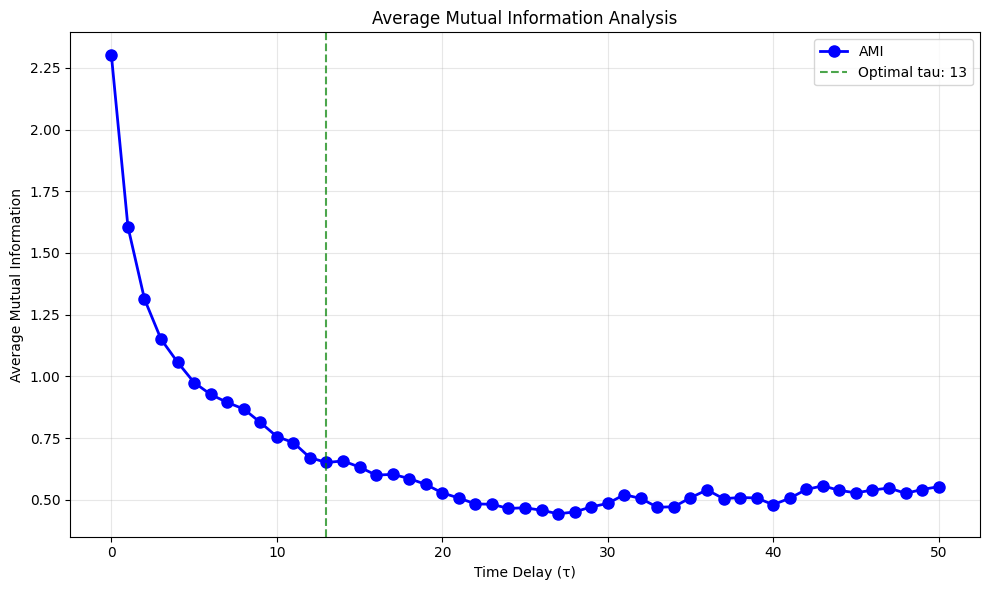

FNN process
Optimal embedding dimension: 4
FNN ratios: [0.92798354 0.21413721 0.03177966 0.0043573  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


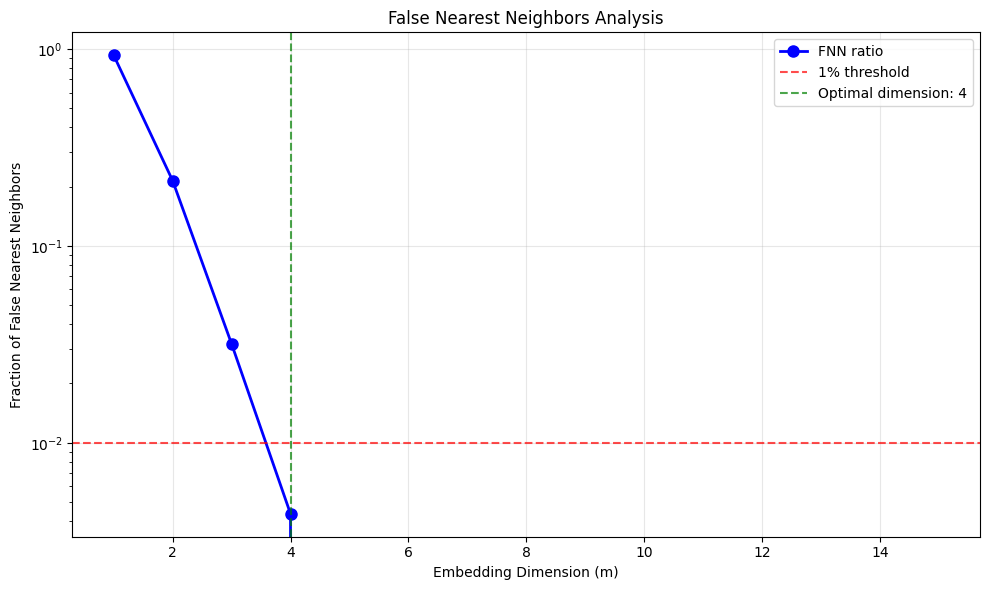

-----  DETERMINED -----
Optimal DIMESION: 4
Optimal TAU: 13
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
-----  VISUALIZE -----
PSR comparison using optimal obtained values


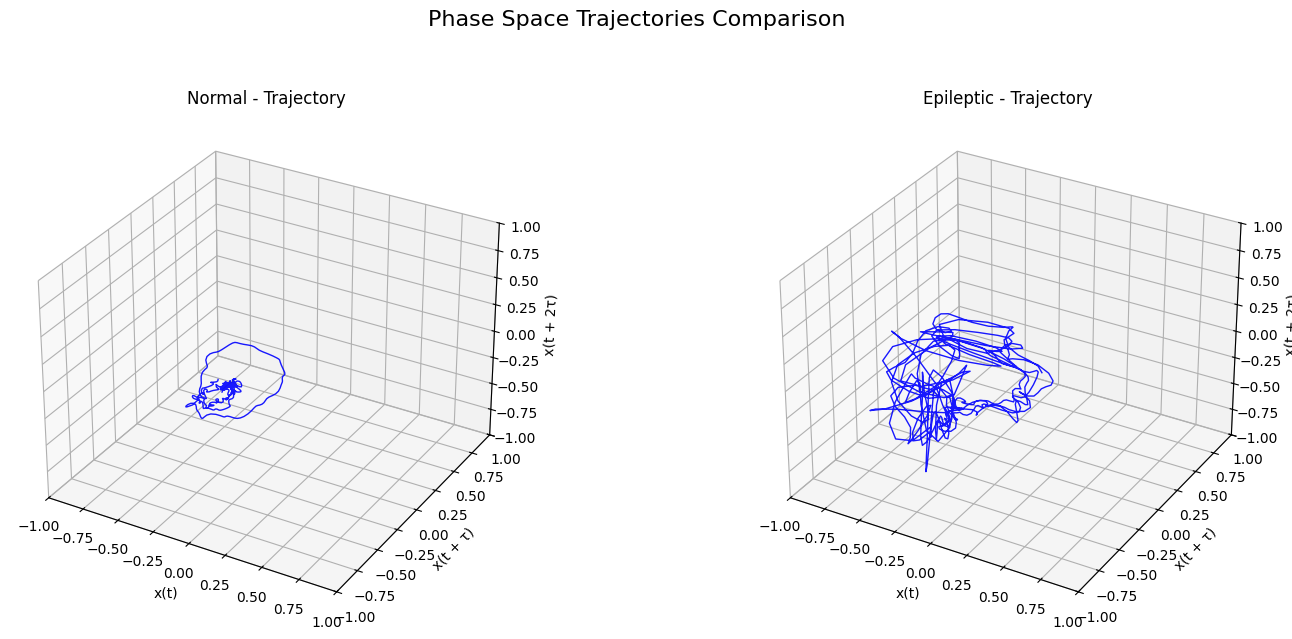

RQA analysis testing
Standard deviation of normal segment: 0.0884
Standard deviation of epileptic segment: 0.2061
Threshold for normal segment: 0.1000
Threshold for epileptic segment: 0.1000
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
RQA Metrics for Normal Segment:
RR: 0.1633
DET: 0.9940
L: 14.4987
LAM: 0.9962
L/RR: 88.7919681802592

RQA Metrics for Epileptic Segment:
RR: 0.0157
DET: 0.6396
L: 3.4039
LAM: 0.7825
L/RR: 216.95668420594598
Visualizing Recurrence Plots


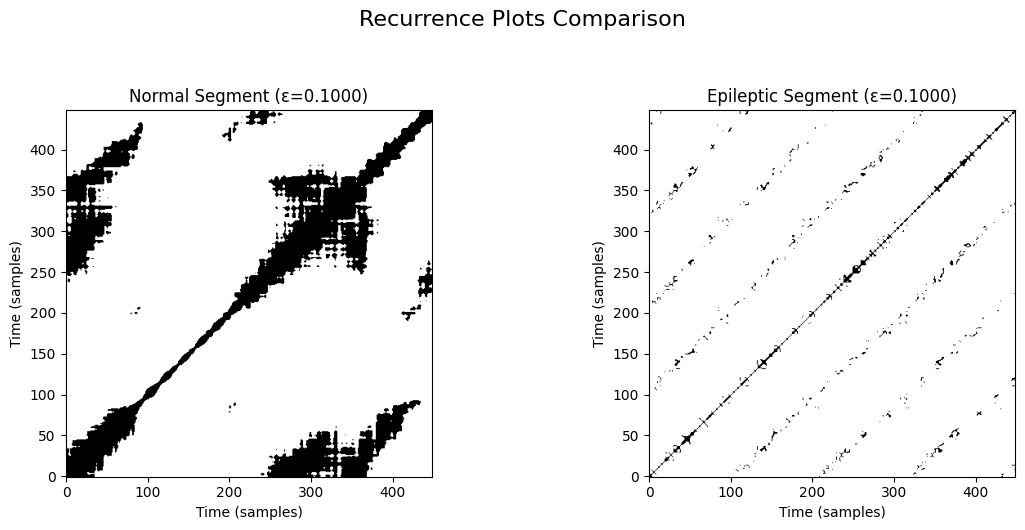

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from google.colab import drive, files
from scipy import signal  # Added for filtering
from tqdm.auto import tqdm
!pip install pyunicorn
from pyunicorn.timeseries import RecurrenceNetwork, RecurrencePlot
from scipy.signal import welch
from scipy.spatial import ConvexHull
from numpy.linalg import norm

# testing on one channel
selected_channel = 'P8-O2'
selected_channel = 'FT10-T8'
selected_channel = 'FP1-F7'

# Mount Google Drive
drive.mount('/content/drive')


# Define a range of different frequency bands for spectral analysis
FREQUENCY_BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    #'alpha': (8, 13),
    #'beta': (13, 30),
    #'gamma': (30, 100)
}

def filter_signal(data, sfreq, low_freq, high_freq, order=4):
    """
    Apply a bandpass filter to isolate a specific frequency band.

    Parameters:
    data: 1D numpy array (time series)
    sfreq: Sampling frequency (Hz)
    low_freq: Lower frequency bound (Hz)
    high_freq: Upper frequency bound (Hz)
    order: Butterworth filter order
    Returns:
    filtered_data: Filtered time series
    """
    nyquist = sfreq / 2.0
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data


def find_optimal_tau_ami(time_series, max_tau=50, bins=16, smooth_window=None):
    """
    Compute AMI (via average_mutual_information) and return the first local minimum
    (τ >= 1). If no local minimum is found, fall back to the rule of 1/e.

    Returns: optimal_tau (int), ami_curve (np.array indexed by τ=0..max_tau)
    """
    ami_curve = average_mutual_information(time_series, max_tau=max_tau, bins=bins)

    # optional smoothing (helps with noisy AMI curves)
    if smooth_window and smooth_window > 1:
        from scipy.ndimage import uniform_filter1d
        ami_curve = uniform_filter1d(ami_curve, size=smooth_window, mode='nearest')

    #  local-minimum detection (search τ = 1 .. max_tau-1)
    if len(ami_curve) >= 3:
        # check interior points: ami[1]..ami[-2] compared with neighbors
        interior = ami_curve[1:-1]
        left   = ami_curve[:-2]
        right  = ami_curve[2:]
        local_min_mask = (interior < left) & (interior < right)
        local_mins = np.where(local_min_mask)[0]
        if local_mins.size > 0:
            # local_mins[0] corresponds to ami index = (local_mins[0] + 1)
            optimal_tau = int(local_mins[0] + 1)
            return optimal_tau, ami_curve

    # fallback: 1/e rule (first τ where AMI < initial/ e)
    initial_ami = ami_curve[0]
    threshold = initial_ami * (1.0 / np.e)
    candidate_taus = np.where(ami_curve < threshold)[0]
    optimal_tau = int(candidate_taus[0]) if candidate_taus.size > 0 else 1

    return optimal_tau, ami_curve

def average_mutual_information(x, max_tau=50, bins=16):
    """
    Computation of Average Mutual Information (AMI) for selected delays 0...max_tau.

    Parameters:
    x : 1D numpy array (time series)
    max_tau : maximum time delay
    bins : number of bins for histogram

    Returns:
    ami : numpy array of AMI values
    """
    # Digitize signal into bins
    hist, bin_edges = np.histogram(x, bins=bins)
    digitized = np.digitize(x, bin_edges[:-1])

    ami = []
    for tau in range(max_tau+1):
        if tau == 0:
            # AMI at lag 0 is entropy of distribution
            mi = mutual_info_score(digitized, digitized)
        else:
            mi = mutual_info_score(digitized[:-tau], digitized[tau:])
        ami.append(mi)
    return np.array(ami)

def find_optimal_dimension(fnn_ratio, threshold=0.02, stability_window=2):
    """
    Find optimal embedding dimension using the Kennel et al. criterion.
    Returns the first dimension where FNN drops below threshold and stays stable.

    Parameters:
    fnn_ratio: array of FNN percentages for each dimension
    threshold: maximum acceptable FNN percentage (typically 1-5%)
    stability_window: number of consecutive dimensions that must stay low

    Returns:
    optimal_dim: optimal embedding dimension
    """
    # Look for the first dimension where FNN drops below threshold
    # and remains consistently low for the next few dimensions
    for d in range(len(fnn_ratio) - stability_window):
        current_window = fnn_ratio[d:d+stability_window]

        # Check if all values in the window are below threshold
        # and that they don't show an increasing trend (noise amplification)
        if (np.all(current_window <= threshold) and
            not np.any(np.diff(current_window) > 0.005)):  # avoid increasing trend
            return d + 1  # +1 because dimensions start at 1

    # Fallback: return dimension with minimum FNN that's below reasonable threshold
    candidate_dims = np.where(fnn_ratio <= 0.05)[0]  # dimensions with FNN ≤ 5%
    if len(candidate_dims) > 0:
        return candidate_dims[0] + 1

    # Final fallback: dimension with absolute minimum FNN
    return np.argmin(fnn_ratio) + 1

def false_nearest_neighbors(time_series, tau=1, max_dim=10, rtol=15.0, atol=2.0):
    """
    implementινγ the False Nearest Neighbors algorithm based on:
    Kennel, M. B., Brown, R., & Abarbanel, H. D. I. (1992).
    Determining embedding dimension for phase-space reconstruction using a geometrical construction.
    Physical Review A, 45(6), 3403.

    Parameters:
    time_series: 1D array of scalar measurements
    tau: time delay
    max_dim: maximum embedding dimension to test
    rtol: tolerance for relative distance criterion
    atol: tolerance for absolute distance criterion

    Returns:
    fnn_ratio: array of false nearest neighbor ratios for each dimension
    optimal_dim: optimal embedding dimension
    """
    n = len(time_series)
    fnn_ratio = np.zeros(max_dim)
    R_d = np.std(time_series)  # attractor size estimate

    # For each dimension from 1 to max_dim
    for d in range(1, max_dim + 1):
        # Build phase-space vectors in dimension d
        n_vectors = n - (d-1)*tau
        if n_vectors <= 0:
            fnn_ratio[d-1] = 1.0
            continue

        phase_space_d = np.zeros((n_vectors, d))
        for i in range(n_vectors):
            for j in range(d):
                phase_space_d[i, j] = time_series[i + j*tau]

        # Find nearest neighbors in d dimensions using KDTree for efficiency
        tree = KDTree(phase_space_d)
        dists_d, indices_d = tree.query(phase_space_d, k=2)  # k=2 to exclude self
        nearest_dists = dists_d[:, 1]  # distances to nearest neighbor
        nearest_indices = indices_d[:, 1]  # indices of nearest neighbors

        false_count = 0
        valid_pairs = 0

        # Check each point for false neighbors when moving to dimension d+1
        for i in range(n_vectors):
            j = nearest_indices[i]  # index of nearest neighbor in d-dim

            # Skip if we can't compute the (d+1)th coordinate
            if (i + d*tau >= n) or (j + d*tau >= n):
                continue

            dist_d = nearest_dists[i]

            # Get the next coordinate in dimension d+1 (Eq. 3 in paper)
            x_i_next = time_series[i + d*tau]
            x_j_next = time_series[j + d*tau]
            new_coord_diff = x_i_next - x_j_next

            # Compute new distance in d+1 using Pythagorean theorem
            dist_d_plus_1 = np.sqrt(dist_d**2 + new_coord_diff**2)

            # Apply both criteria (Eq. 4 and 5 in paper)
            if dist_d > 1e-10:  # avoid division by zero
                # Criterion 1: Relative distance increase
                criterion1 = (abs(new_coord_diff) / dist_d) > rtol

                # Criterion 2: Absolute distance relative to attractor size
                criterion2 = (dist_d_plus_1 / R_d) > atol

                if criterion1 or criterion2:
                    false_count += 1

                valid_pairs += 1

        fnn_ratio[d-1] = false_count / valid_pairs if valid_pairs > 0 else 0


    optimal_dim = find_optimal_dimension(fnn_ratio, threshold=0.02, stability_window=2)

    return fnn_ratio, optimal_dim

def plot_fnn_results(fnn_ratio, optimal_dim):
    """Plot FNN analysis results with proper formatting"""
    dimensions = range(1, len(fnn_ratio) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(dimensions, fnn_ratio, 'bo-', linewidth=2, markersize=8, label='FNN ratio')
    plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.7, label='1% threshold')
    plt.axvline(x=optimal_dim, color='g', linestyle='--', alpha=0.7,
                label=f'Optimal dimension: {optimal_dim}')

    plt.xlabel('Embedding Dimension (m)')
    plt.ylabel('Fraction of False Nearest Neighbors')
    plt.title('False Nearest Neighbors Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

def load_single_channel(npy_path, metadata_path, channel_name):
    """Load a single EEG channel into a NumPy array."""
    # Load data and metadata
    data = np.load(npy_path)
    metadata = np.load(metadata_path, allow_pickle=True).item()
    channels = metadata['channels']  # List of channel names
    times = metadata['times']

    # Print shapes for debugging
    print(f"Shape of loaded data: {data.shape}")
    print(f"Expected shape from metadata: ({len(channels)}, {len(times)})")


    # Find index of the selected channel
    try:
        channel_idx = channels.index(channel_name)
    except ValueError:
        raise ValueError(f"Channel {channel_name} not found in {channels}")

    # Extract the single channel data
    single_channel_data = data[channel_idx]

    print(f"Loaded channel {channel_name} with {len(single_channel_data)} samples")

    return single_channel_data, times

def plot_single_channel(data, times, channel_name):
    """Plot the single channel data."""
    plt.figure(figsize=(12, 4))
    plt.plot(times, data, linewidth=0.8)
    plt.title(f"EEG Data: Channel {channel_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def create_phase_space_vectors(segment_data, m=3, tau=1):
    # Check if segment_data is long enough for embedding
    n_samples = len(segment_data)
    if n_samples < m * tau:
        raise ValueError(f"Segment length ({n_samples}) is too short for m={m} and tau={tau}")

    # Calculate the number of phase space vectors
    n_vectors = n_samples - (m - 1) * tau
    print("creating {n_vectors} vectors")

    # Initialize array to store phase space vectors
    phase_space_vectors = np.zeros((n_vectors, m))

    # Construct phase space vectors using a for loop
    for i in range(n_vectors):
        for j in range(m):
            phase_space_vectors[i, j] = segment_data[i + j * tau]

    print(f"Created {n_vectors} phase space vectors with m={m} and tau={tau}")

    return phase_space_vectors



def plot_ami_results(ami_curve, optimal_tau, max_tau):
    """Plot AMI analysis results with proper formatting"""
    taus = range(len(ami_curve))

    plt.figure(figsize=(10, 6))
    plt.plot(taus, ami_curve, 'bo-', linewidth=2, markersize=8, label='AMI')
    plt.axvline(x=optimal_tau, color='g', linestyle='--', alpha=0.7,
                label=f'Optimal tau: {optimal_tau}')

    plt.xlabel('Time Delay (τ)')
    plt.ylabel('Average Mutual Information')
    plt.title('Average Mutual Information Analysis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_phase_space(phase_space_vectors, title, ax=None):
    if phase_space_vectors.shape[1] != 3:
        raise ValueError("Phase space vectors must have 3 dimensions for 3D visualization")

    # If no ax is provided, create a new figure with 3D axes
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates
    x = phase_space_vectors[:, 0]
    y = phase_space_vectors[:, 1]
    z = phase_space_vectors[:, 2]

    # Plot the trajectory with connected lines in black
    ax.plot(x, y, z, linewidth=1, alpha=0.9, color='blue')

    # Set labels
    ax.set_xlabel('x(t)')
    ax.set_ylabel('x(t + τ)')
    ax.set_zlabel('x(t + 2τ)')
    ax.set_title(f'{title} - Trajectory')

    # Set equal axis scaling
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

def compare_phase_space(normal_psv, epileptic_psv):
    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=(16, 6))  # Adjusted figure size for side-by-side plots
    fig.suptitle('Phase Space Trajectories Comparison', fontsize=16, y=1.05)
    # Create first subplot for normal phase space
    ax1 = fig.add_subplot(121, projection='3d')
    visualize_phase_space(normal_psv[:, :3], "Normal", ax=ax1)

    # Create second subplot for epileptic phase space
    ax2 = fig.add_subplot(122, projection='3d')
    visualize_phase_space(epileptic_psv[:, :3], "Epileptic", ax=ax2)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

#### main execution


if __name__ == "__main__":

    npy_path = "/content/drive/My Drive/EEG_Processed/pat24/epileptic/p24_01_filtered.npy"
    metadata_path = "/content/drive/My Drive/EEG_Processed/pat24/epileptic/p24_01_metadata.npy"
    # Load sampling frequency from metadata
    metadata = np.load(metadata_path, allow_pickle=True).item()
    sfreq = metadata['sfreq']  # Sampling frequency in Hz
    print(f"Sampling frequency: {sfreq} Hz")



    """
    File Name: chb24_01.edf
    Number of Seizures in File: 2
    Seizure Start Time: 480 seconds    sample 122800
    Seizure End Time: 505 seconds     sample  129280
    Seizure Start Time: 2451 seconds  sample 627456
    Seizure End Time: 2476 seconds    sample 633856
    """
    SEG_SIZE = 768
    SEG_SIZE = 512
    #set epileptic sample index and normal sample index
    #epileptic_idx = 125456
    epileptic_idx = 629000

    normal_idx = 0
    normal_idx = 100050

    # Load single channel data on an array.
    channel_data, times = load_single_channel(npy_path, metadata_path, selected_channel)
    print(f"Loaded channel data with shape: {channel_data.shape}")
    print(f"Loaded times with shape: {times.shape}")
    print(f"Loaded metadata with keys: {metadata.keys()}")

    # Plot the single channel
    plot_single_channel(channel_data, times, selected_channel)


    print("Compare phase space reconstruction for 10 normal vs 10 epileptic 1-sec segments.")

    # Generate 10 comparative PSR figures
    for i in range(1):
        # shift indices so each iteration takes a new segment
        normal_start = normal_idx + i * SEG_SIZE
        epileptic_start = epileptic_idx + i * SEG_SIZE
        print(normal_start)
        print(epileptic_start)
        normal_segment = channel_data[normal_start:normal_start+SEG_SIZE]
        epileptic_segment = channel_data[epileptic_start:epileptic_start+SEG_SIZE]
        # Embed phase space (here I fixed m=5, tau=20; you can replace with your optimal)
        psv_normal = create_phase_space_vectors(normal_segment, m=optimal_dim, tau=optimal_tau)
        psv_epileptic = create_phase_space_vectors(epileptic_segment, m=optimal_dim, tau=optimal_tau)
        compare_phase_space(psv_normal,psv_epileptic)


    init_idx = normal_idx


    print(f"Creating {SEG_SIZE/sfreq}-second segments")
    #create a N-seconds segment.
    segment_data = channel_data[init_idx:init_idx+SEG_SIZE]
    segment_time = times[init_idx:init_idx+SEG_SIZE]
    plot_single_channel(segment_data, segment_time, selected_channel)
    epileptic_segment = channel_data[epileptic_idx:epileptic_idx+SEG_SIZE]
    epileptic_time = times[epileptic_idx:epileptic_idx+SEG_SIZE]
    plot_single_channel(epileptic_segment, epileptic_time, selected_channel)


    print("AMI process")
    #  determining the optimal tau by using AMI
    max_tau_to_test = 50

    optimal_tau, ami_curve = find_optimal_tau_ami(segment_data, max_tau=max_tau_to_test)
    plot_ami_results(ami_curve, optimal_tau, max_tau_to_test) # Visualize the AMI curve

    print("FNN process")
    #application of the FNN false nearest neighbors method
    fnn_ratio, optimal_dim = false_nearest_neighbors( segment_data, tau=optimal_tau, max_dim=15, rtol=15.0, atol=2.0)

    print(f"Optimal embedding dimension: {optimal_dim}")
    print("FNN ratios:", fnn_ratio)

    plot_fnn_results(fnn_ratio, optimal_dim)

    #embedding parameters
    m = optimal_dim
    tau = optimal_tau


    ### results based on a normal segment, printing them
    print("-----  DETERMINED -----")
    print(f"Optimal DIMESION: {optimal_dim}")
    print(f"Optimal TAU: {optimal_tau}")
    psv = create_phase_space_vectors(segment_data, m = optimal_dim, tau = optimal_tau)
    epileptic_psv = create_phase_space_vectors(epileptic_segment, m = optimal_dim, tau = optimal_tau)
    print("-----  VISUALIZE -----")
    print("PSR comparison using optimal obtained values")
    compare_phase_space(psv,epileptic_psv)

    #print("visualizing normal segment PSR")
    # visualize 3D , make sure only 3 dimensions are there.
    #visualize_phase_space(psv[:, :3],"full")



    print("RQA analysis testing")
    # Calculate standard deviation of the normal and epileptic segments
    std_normal = np.std(segment_data)
    std_epileptic = np.std(epileptic_segment)
    print(f"Standard deviation of normal segment: {std_normal:.4f}")
    print(f"Standard deviation of epileptic segment: {std_epileptic:.4f}")

    # Set threshold as a fraction of the segment's std (e.g., 10% of std)
    threshold_factor = 0.25  # Adjust this (e.g., 0.05 to 0.2) based on desired recurrence rate
    epsilon_normal = std_normal * threshold_factor
    epsilon_epileptic = std_epileptic * threshold_factor

    #fix values
    FIX_E = 0.1
    epsilon_normal = FIX_E
    epsilon_epileptic = FIX_E
    print(f"Threshold for normal segment: {epsilon_normal:.4f}")
    print(f"Threshold for epileptic segment: {epsilon_epileptic:.4f}")

    # Initialize RecurrencePlot for normal segment
    rp_normal = RecurrencePlot(psv_normal, threshold=epsilon_normal, metric='euclidean')
    rqa_metrics_normal = rp_normal.rqa_summary()

    # Initialize RecurrencePlot for epileptic segment
    rp_epileptic = RecurrencePlot(psv_epileptic, threshold=epsilon_epileptic, metric='euclidean')
    rqa_metrics_epileptic = rp_epileptic.rqa_summary()
    # Assign L and RR to variables
    L_normal = rqa_metrics_normal['L']
    RR_normal = rqa_metrics_normal['RR']
    L_epileptic = rqa_metrics_epileptic['L']
    RR_epileptic = rqa_metrics_epileptic['RR']
    # Print RQA metrics
    print("RQA Metrics for Normal Segment:")
    for metric, value in rqa_metrics_normal.items():
        print(f"{metric}: {value:.4f}")
    print(f"L/RR: {L_normal/RR_normal}")

    print("\nRQA Metrics for Epileptic Segment:")
    for metric, value in rqa_metrics_epileptic.items():
        print(f"{metric}: {value:.4f}")
    print(f"L/RR: {L_epileptic/RR_epileptic}")
    # Optional: Visualize recurrence plots
    print("Visualizing Recurrence Plots")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Recurrence Plots Comparison', fontsize=16, y=1.05)

    # Plot normal segment recurrence plot
    ax1.imshow(rp_normal.recurrence_matrix(), cmap='binary', origin='lower')
    ax1.set_title(f'Normal Segment (ε={epsilon_normal:.4f})')
    ax1.set_xlabel('Time (samples)')
    ax1.set_ylabel('Time (samples)')

    # Plot epileptic segment recurrence plot
    ax2.imshow(rp_epileptic.recurrence_matrix(), cmap='binary', origin='lower')
    ax2.set_title(f'Epileptic Segment (ε={epsilon_epileptic:.4f})')
    ax2.set_xlabel('Time (samples)')
    ax2.set_ylabel('Time (samples)')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()



Streaming output truncated to the last 5000 lines.
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
creating {n_vectors} vectors
Created 473 phase space vectors with m=4 and tau=13
Calculating recurrence plot at fixed threshold...
Calculating the euclidean distance matrix...
creating {n_vectors} vectors
Created 473 phase space vectors with m=4

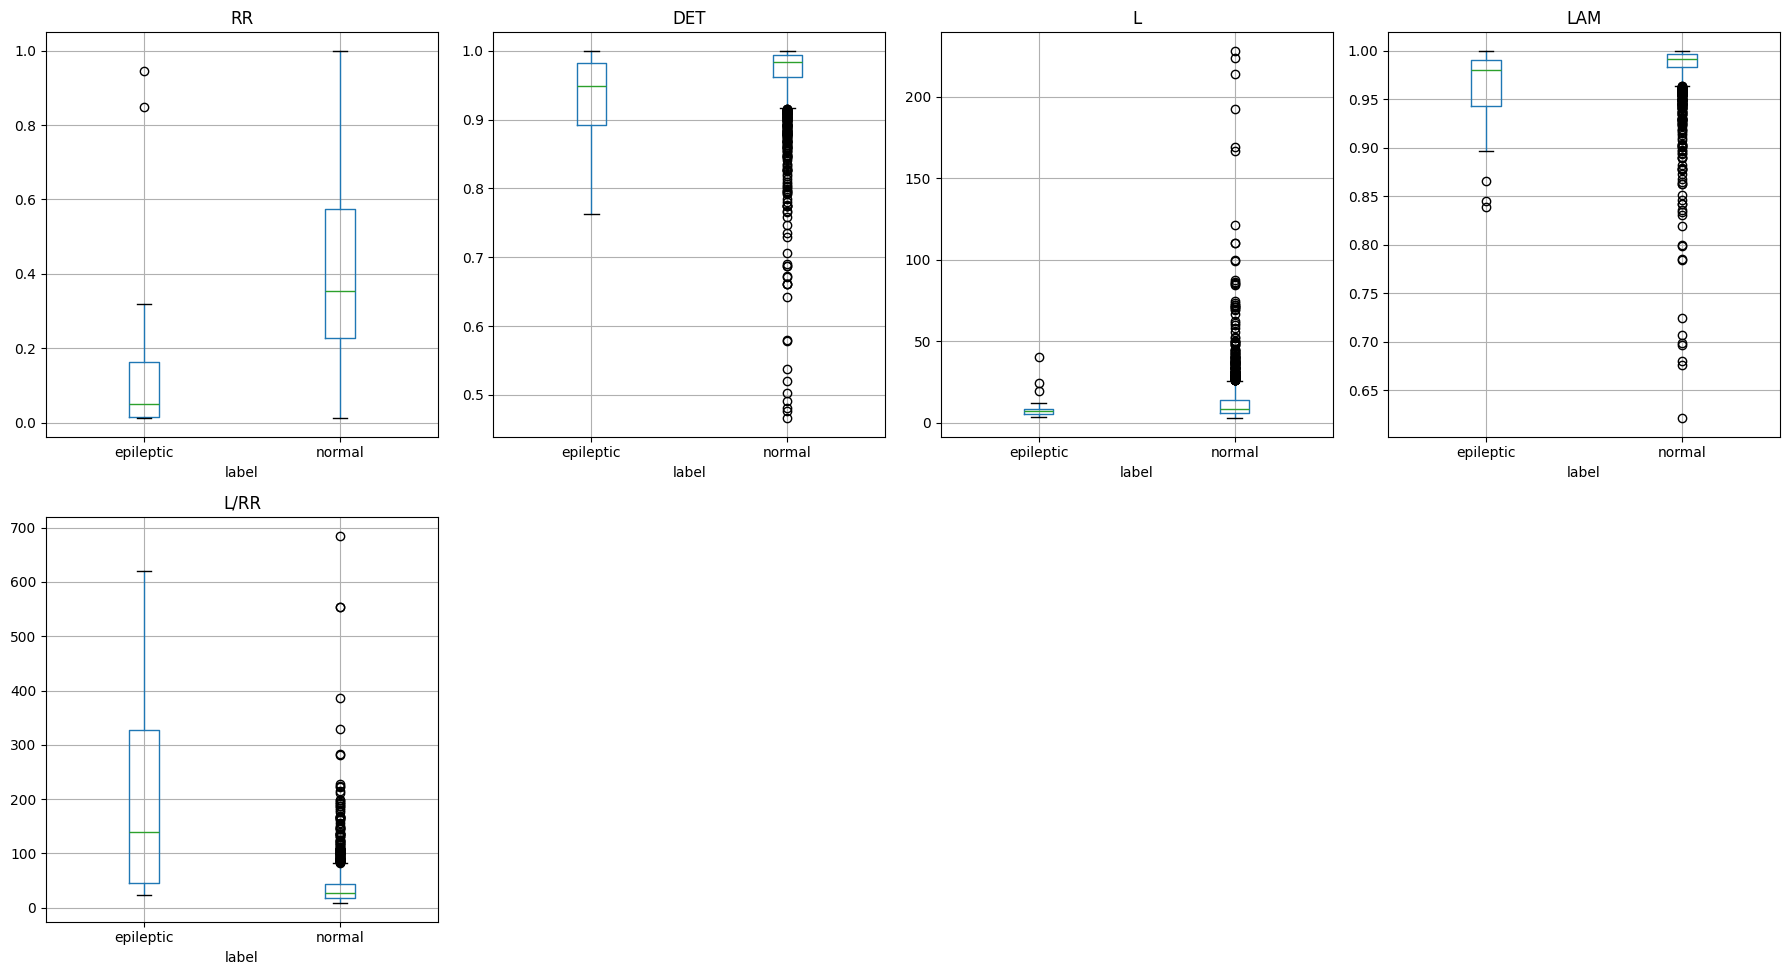

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# seizure intervals (from metadata you wrote)
seizure_intervals = [
    (122800, 129280),   # Seizure 1
    (627456, 633856)    # Seizure 2
]



def is_epileptic_segment(start_idx, end_idx, seizure_intervals):
    """Return True if segment overlaps with seizure intervals."""
    for (sz_start, sz_end) in seizure_intervals:
        if not (end_idx < sz_start or start_idx > sz_end):  # overlap condition
            return True
    return False


# storage for results
results = []

# iterate over non-overlapping segments
n_segments = len(channel_data) // SEG_SIZE
for i in range(n_segments):
    seg_start = i * SEG_SIZE
    seg_end = seg_start + SEG_SIZE
    segment = channel_data[seg_start:seg_end]

    # Skip incomplete last segment if needed
    if len(segment) < SEG_SIZE:
        continue

    # Check if this segment is epileptic
    label = "epileptic" if is_epileptic_segment(seg_start, seg_end, seizure_intervals) else "normal"

    # Create PSR with previously found parameters
    psv = create_phase_space_vectors(segment, m=optimal_dim, tau=optimal_tau)

    # Use fixed threshold for both
    rp = RecurrencePlot(psv, threshold=FIX_E, metric='euclidean')
    rqa_metrics = rp.rqa_summary()

    # Store results
    results.append({
        "segment": i,
        "label": label,
        "RR": rqa_metrics['RR'],
        "DET": rqa_metrics['DET'],
        "L": rqa_metrics['L'],

        "LAM": rqa_metrics['LAM'],

        "L/RR": rqa_metrics['L'] / rqa_metrics['RR'] if rqa_metrics['RR'] > 0 else np.nan
    })

# Convert to DataFrame
df = pd.DataFrame(results)

# --- BOXPLOTS ---
metrics_to_plot = ["RR", "DET", "L", "LAM", "L/RR"]

plt.figure(figsize=(18, 10))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 4, i)
    df.boxplot(column=metric, by="label", ax=plt.gca())
    plt.title(metric)
    plt.suptitle("")  # remove automatic suptitle
plt.tight_layout()
plt.show()